<br>
<section style="font-family:Times New Roman"><br>
    <strong style= "font-weight: bold; color:#0e1a40; font-size:35px;"><i>Regression of Used Car Prices | Py</i></strong><br><br>
    <b style= "font-weight: bold; color:#000000; font-size:20px;"> By: <i>Kheirallah Samaha</i></b><br><br>
    <b style= "font-weight: bold; color:#000000; font-size:17px;"> Date: Sep-06-2024</b>
</section>

**Dataset Description:**
<br>
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Used Car Price Prediction Dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.
<br>
<br>
**Files:**
<br>
<br>
**train.csv -**  the training dataset; price is the continuous target.   
**test.csv -** the test dataset; your objective is to predict the value of price for each row.   
**sample_submission.csv -** a sample submission file in the correct format   

## Import libraries

In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import seaborn as sns
import re
from sklearn import metrics
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from lightgbm import LGBMRegressor

warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="ticks", palette="RdBu")

## Load the Datasets

In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s4e9/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s4e9/test.csv")
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')

## First Five Rows

In [3]:
train_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


## Model year to Object data type

In [4]:
train_df["model_year"] = train_df["model_year"].astype("object")
test_df["model_year"] = test_df["model_year"].astype("object")

## Data Information

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  object
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(3), object(10)
memory usage: 18.7+ MB


## Missing Data

In [6]:
 train_df.isnull().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

## Drop ID Column and check unique values

In [7]:
train_df = train_df.drop("id", axis = "columns")
test_df = test_df.drop("id", axis = "columns")
train_df.nunique()

brand             57
model           1897
model_year        34
milage          6651
fuel_type          7
engine          1117
transmission      52
ext_col          319
int_col          156
accident           2
clean_title        1
price           1569
dtype: int64

## Describe

In [8]:
train_df.describe().round(2).style.format(precision=2).background_gradient(cmap="Blues")

,milage,price
count,188533.00,188533.00
mean,65705.30,43878.02
std,49798.16,78819.52
min,100.00,2000.00
25%,24115.00,17000.00
50%,57785.00,30825.00
75%,95400.00,49900.00
max,405000.00,2954083.00


## Target Variable Distribution | Price

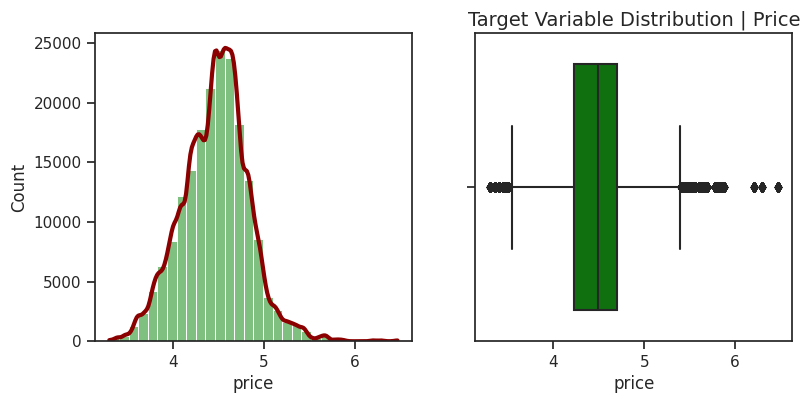

In [9]:

fig, ax = plt.subplots(1,2, figsize=(9, 4))
sns.histplot(
    x = np.log10(train_df['price']),
    stat='count',  
    kde= True, 
    bins = 30,
    color="green",
    line_kws={"lw": 3},
    ax = ax[0]
).lines[0].set_color("darkred")

sns.boxplot(
    x = np.log10(train_df['price']), 
    color="green",
    ax = ax[1])

plt.title("Target Variable Distribution | Price", fontsize=14)
plt.show()

## Milage VS Price by Accident

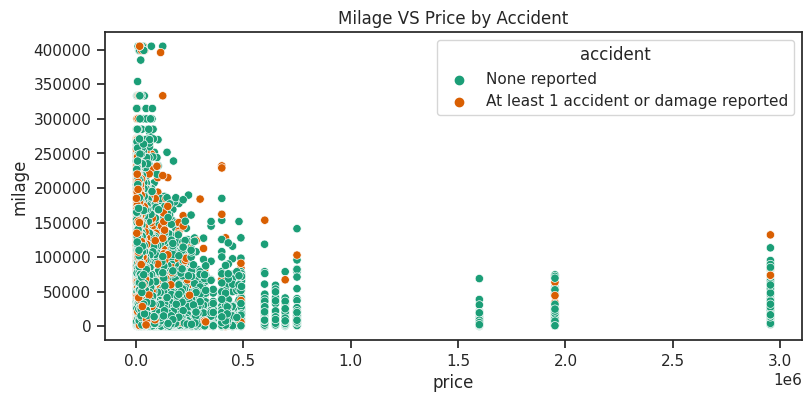

In [10]:
plt.figure(figsize=(9, 4))
sns.scatterplot(data = train_df, x= "price", y = "milage", hue = "accident", palette = "Dark2")
plt.title("Milage VS Price by Accident")
plt.show()

## Milage as a function of Price | lowess | Log 10

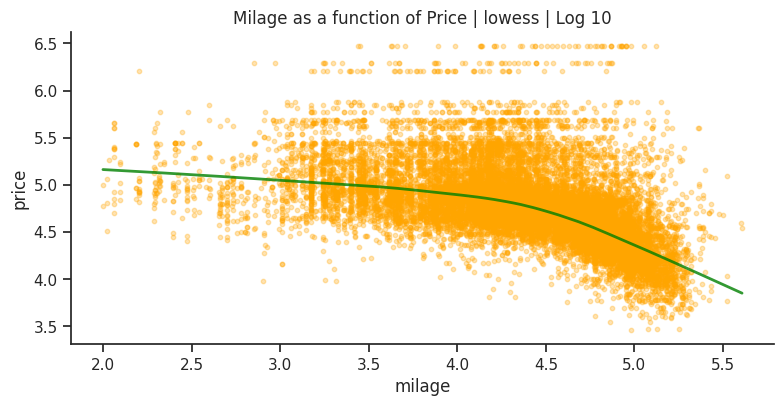

In [11]:
sns.lmplot(
    data=np.log10(train_df[["price","milage"]].sample(frac=0.1, weights='price', random_state=1)),
    x='milage',
    y='price',
    ci=0.95,
    lowess=True,
    height=4,
    aspect=2,
    scatter_kws={"s": 10, "alpha": 0.3, "color": "orange"},
    line_kws={"linewidth": 2, "alpha": 0.8, "color": "green"}
)
plt.title("Milage as a function of Price | lowess | Log 10")
plt.show()

## Linear Model Summary | Price as a function of Milage | Log 10

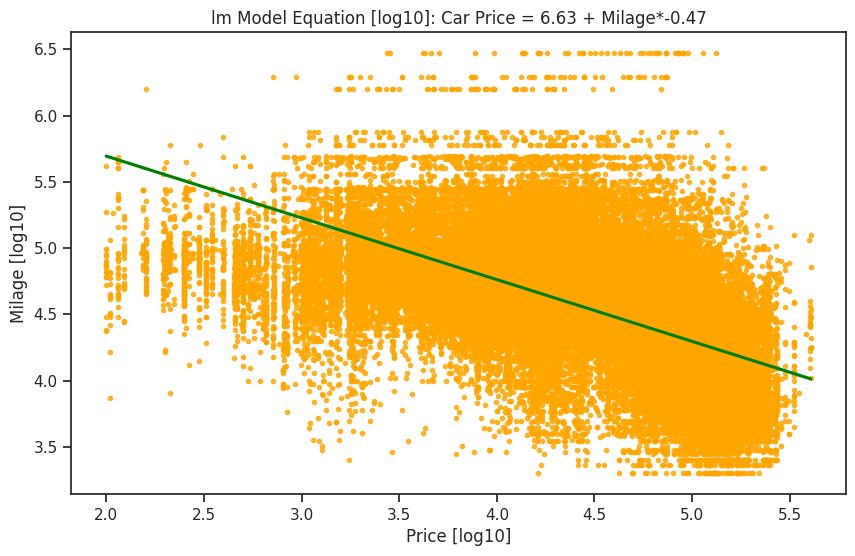

In [12]:

X = np.log10(train_df[['milage']])
y = np.log10(train_df[['price']])
reg_model = LinearRegression().fit(X, y)

plt.figure(figsize=(10, 6))
g = sns.regplot(
    x=X,
    y=y,
    scatter_kws={"color": "orange", "s": 9},
    ci=False,
    color="green",
)
g.set_title(
    f"lm Model Equation [log10]: Car Price = {round(reg_model.intercept_[0], 2)} + Milage*{round(reg_model.coef_[0][0], 2)}"
)
g.set_ylabel("Milage [log10]")
g.set_xlabel("Price [log10]")
plt.show()

## Accident distributions by Fuel type

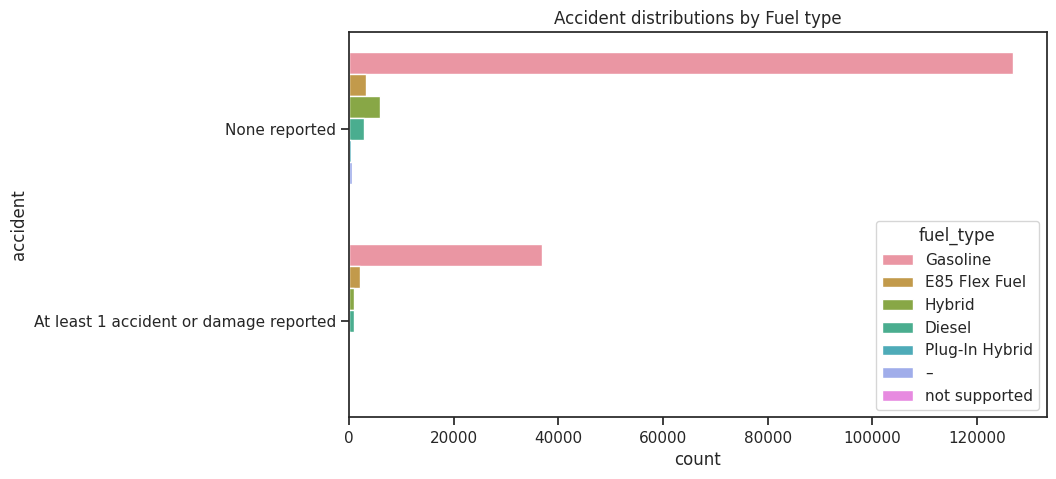

In [13]:
plt.figure(figsize=(9, 5))
sns.countplot(data = train_df, y= "accident", hue = "fuel_type")
plt.title("Accident distributions by Fuel type")
plt.show()

## Fuel type distribution

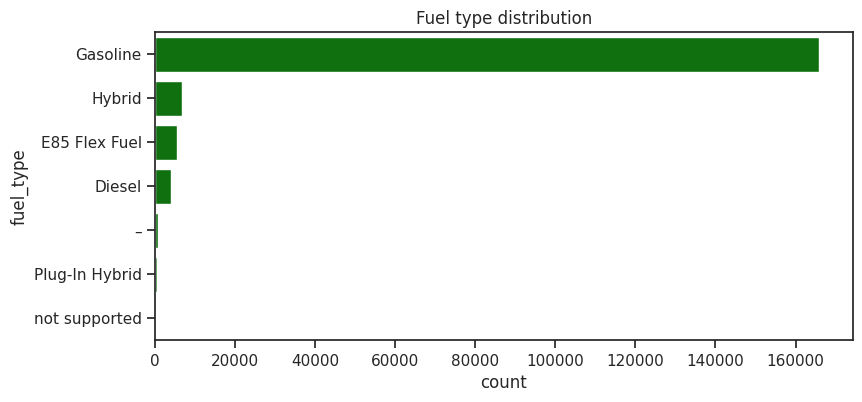

In [14]:
plt.figure(figsize=(9, 4))
sns.countplot(
    data=train_df,
    y="fuel_type",
    order=train_df["fuel_type"].value_counts().index,
    color = "green"
)
plt.title("Fuel type distribution")
plt.show()

## Brand Distribution

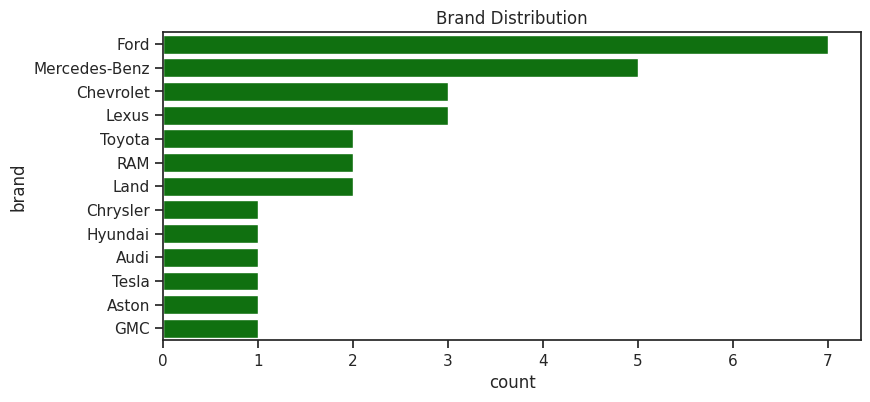

In [15]:
plt.figure(figsize=(9, 4))
sns.countplot(
    data=train_df.nlargest(30, "price"),
    y="brand",
    order=train_df.nlargest(30, "price")["brand"].value_counts().index,
    color = "green"
)
plt.title("Brand Distribution")
plt.show()

## Cars Colors Distributions

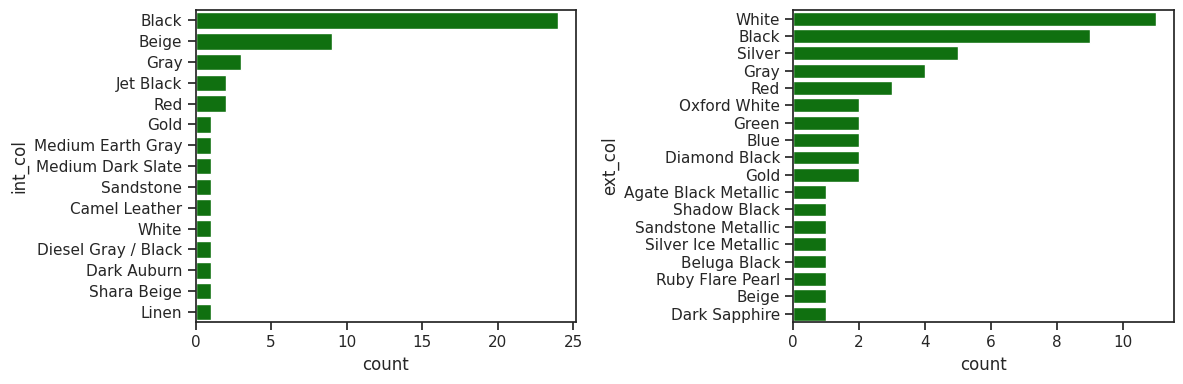

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(
    data=train_df.nlargest(50, "price"),
    y="int_col",
    order=train_df.nlargest(50, "price")["int_col"].value_counts().index,
    color = "green",
    ax=ax[0],
)

sns.countplot(
    data=train_df.nlargest(50, "price"),
    y="ext_col",
    order=train_df.nlargest(50, "price")["ext_col"].value_counts().index,
    color = "green",
    ax=ax[1]
)
plt.tight_layout()
plt.show()

### Milage Correlating with Price

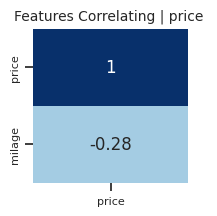

In [17]:
int_vars = train_df.select_dtypes("int64").columns

plt.figure(figsize=(2, 2))
corr_mat2 = train_df[int_vars].corr()
sns.heatmap(
    corr_mat2[["price"]].sort_values(by="price", ascending=False),
    vmin=-1,
    vmax=1,
    cbar=False,
    annot=True,
    cmap="Blues",
    annot_kws={"fontsize":12}
)
plt.title("Features Correlating | price ", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

 ## Model

### Data Transformation

In [18]:
luxurious_brands = [
    "Bentley",
    "Maserati",
    "Lamborghini",
    "Rolls-Royce",
    "Ferrari",
    "McLaren",
    "Aston",
    "Maybach",
]


Top_10_brands = [
    "Tesla",
    "Toyota",
    "BYD",
    "Ferrari",
    "Mercedes-Benz",
    "Porsche",
    "BMW",
    "Xiaomi",
    "Volkswagen",
    "Honda",
]

pattern_v = ["I4", "V6", "V8", "V10", "V12"]

pattern = [
    "A/T",
    "w/Dual",
    "M/T",
    "Automatic",
    "CVT",
    "Auto-Shift",
    "Manual",
    "Variable",
    "F",
    "Overdrive",
    "Electronically",
    "At/Mt",
    "DCT",
    "CVT-F",
    "AT",
]


def preproc(df):
    df.replace("–", np.nan, inplace=True)
    pattern_ex = r"(?:^|\s+)(" + "|".join(pattern) + r")(?:\s+|$)"
    pattern_vex = r"(?:^|\s+)(" + "|".join(pattern_v) + r")(?:\s+|$)"
    df.replace("–", np.nan, inplace=True)
    df["transm_"] = df["transmission"].str.extract(pattern_ex, expand=False)
    df["transm_"] = (
        df["transm_"]
        .replace("A/T", "AT", regex=True)
        .replace(
            {"A/T": "Automatic", "AT": "Automatic", "MT": "Manual", "M/T": "Manual"}
        )
    )
    df["hp"] = df["engine"].str.extract(r"(\d+\.\d+)HP", expand=False)
    df["cyl"] = df["engine"].str.extract("(L.*(?=.Cyl))")
    df["cyl"] = np.where(
        df["cyl"].isnull(),
        df["engine"].str.extract(pattern_vex, expand=False),
        df["cyl"],
    )
    df["cyl"] = df["cyl"].str.extract(r"(\d*\.?\d+)")
    df["engine"] = df["engine"].replace(" Liter", "L")
    df["liter"] = df["engine"].str.extract(r"(\d+\.\d+)L", expand=False)
    df["accident"] = df["accident"].replace(
        {"None reported": 0, "At least 1 accident or damage reported": 1}
    )
    df["luxurious_brands"] = np.where(
        df["brand"].isin(luxurious_brands), "luxury", "regular"
    )
    df["top_10_brands"] = np.where(
        df["brand"].isin(luxurious_brands), "top_10", "unranked"
    )
    df["rank"] = (df["milage"].astype(str)+ "_" + df["hp"].astype(str) + "_" + df["cyl"].astype(str))
    df["rank"] = df["rank"].rank(method="dense")
    df = df.drop(["transmission", "engine"], axis=1)
    list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
    df[list_str_obj_cols] = df[list_str_obj_cols].astype("category")
    df[["cyl", "accident"]] = df[["cyl", "accident"]].astype("category")
    df[["hp", "liter"]] = df[["hp", "liter"]].astype("float64")
    return df

## Train Data preprocessing

In [19]:
train_df_for_model = preproc(train_df)
train_df_for_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   brand             188533 non-null  category
 1   model             188533 non-null  category
 2   model_year        188533 non-null  category
 3   milage            188533 non-null  int64   
 4   fuel_type         182669 non-null  category
 5   ext_col           188167 non-null  category
 6   int_col           184006 non-null  category
 7   accident          186081 non-null  category
 8   clean_title       167114 non-null  category
 9   price             188533 non-null  int64   
 10  transm_           188240 non-null  category
 11  hp                155274 non-null  float64 
 12  cyl               172766 non-null  category
 13  liter             174319 non-null  float64 
 14  luxurious_brands  188533 non-null  category
 15  top_10_brands     188533 non-null  category
 16  ra

## Test Data preprocessing

In [20]:
test_df_for_model = preproc(test_df)
test_df_for_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   brand             125690 non-null  category
 1   model             125690 non-null  category
 2   model_year        125690 non-null  category
 3   milage            125690 non-null  int64   
 4   fuel_type         121769 non-null  category
 5   ext_col           125467 non-null  category
 6   int_col           122737 non-null  category
 7   accident          124058 non-null  category
 8   clean_title       111451 non-null  category
 9   transm_           125501 non-null  category
 10  hp                103509 non-null  float64 
 11  cyl               115259 non-null  category
 12  liter             116283 non-null  float64 
 13  luxurious_brands  125690 non-null  category
 14  top_10_brands     125690 non-null  category
 15  rank              125690 non-null  float64 
dtypes:

## Train Test Split

In [21]:
df_for_model = train_df_for_model.groupby('price').sample(frac=1, random_state= 1).reset_index(drop = True)
X = df_for_model.drop(columns=['price'], axis =1)
y = df_for_model['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state = 8
)

## LGBM Regressor

### Hyperparameter Tuning (Optuna)

In [22]:
def objective_lgbm(trial):

    lgbm_params = {
    'n_estimators': trial.suggest_int('n_estimators', 800, 1500),
    'num_leaves': trial.suggest_int('num_leaves', 75, 200),
    'max_depth': trial.suggest_int('max_depth', 12, 30),
    'cat_smooth': trial.suggest_int('cat_smooth', 20, 120),
    'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.02),
    'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
    'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 0.8),
    'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-4, 1.0),
    'min_child_weight': trial.suggest_int('min_child_weight', 5, 70),
    'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-10, 1e-3),
    'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-10, 1e-2),
    #'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, 12.0),
    'max_bin': trial.suggest_int('max_bin', 200, 1000),
    }
    

    # Fit the model
    model_lgbm = LGBMRegressor(
        **lgbm_params, random_state=42, loss_function="RMSE", verbose=-1
    )

    model_lgbm.fit(X_train, y_train)

    # Predict and calculate mean squared error score
    y_pred = model_lgbm.predict(X_test)

    return mean_squared_error(y_test, y_pred, squared = False)

### Create a study object | optimization

In [23]:
study_lgbm = optuna.create_study(
    study_name="LGBM_used_car", 
    #sampler=TPESampler(), 
    direction="minimize"
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgbm.optimize(objective_lgbm, n_trials=35, show_progress_bar=True)

[I 2024-09-16 05:29:11,427] A new study created in memory with name: LGBM_used_car


  0%|          | 0/35 [00:00<?, ?it/s]

## Best trial

In [24]:
print("Best trial:", study_lgbm.best_trial)

Best trial: FrozenTrial(number=22, state=TrialState.COMPLETE, values=[70494.80470292471], datetime_start=datetime.datetime(2024, 9, 16, 5, 47, 19, 663283), datetime_complete=datetime.datetime(2024, 9, 16, 5, 48, 4, 203476), params={'n_estimators': 894, 'num_leaves': 181, 'max_depth': 21, 'cat_smooth': 111, 'learning_rate': 0.004473302167663609, 'subsample': 0.6288441012417281, 'colsample_bytree': 0.5025875081271391, 'min_split_gain': 0.33256130965761277, 'min_child_weight': 60, 'lambda_l2': 1.346095691887569e-10, 'lambda_l1': 0.0011819375470253472, 'max_bin': 706}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1500, log=False, low=800, step=1), 'num_leaves': IntDistribution(high=200, log=False, low=75, step=1), 'max_depth': IntDistribution(high=30, log=False, low=12, step=1), 'cat_smooth': IntDistribution(high=120, log=False, low=20, step=1), 'learning_rate': FloatDistribution(high=0.02, log=True, low=0.001, step=None), 'sub

## Best parameters

In [25]:
print("Best parameters:", study_lgbm.best_params)

Best parameters: {'n_estimators': 894, 'num_leaves': 181, 'max_depth': 21, 'cat_smooth': 111, 'learning_rate': 0.004473302167663609, 'subsample': 0.6288441012417281, 'colsample_bytree': 0.5025875081271391, 'min_split_gain': 0.33256130965761277, 'min_child_weight': 60, 'lambda_l2': 1.346095691887569e-10, 'lambda_l1': 0.0011819375470253472, 'max_bin': 706}


### Visualization optimization history

In [26]:
fig = optuna.visualization.plot_optimization_history(study_lgbm)
fig.update_layout(
    font_family="Courier New",
    font_size=12,
    title_font_family="Times New Roman",
    title_font_color="steelblue",
    legend_title_font_color="black",
    plot_bgcolor='#e9eff6',
    paper_bgcolor='#f5fbf5',
)
fig.update_xaxes(color = "darkgreen")
fig.update_traces(marker_color='green')

### Visualization parameters importances

In [27]:
fig = optuna.visualization.plot_param_importances(study_lgbm)
fig.update_layout(
    font_family="Courier New",
    font_size=12,
    title_font_family="Times New Roman",
    title_font_color="steelblue",
    legend_title_font_color="black",
    plot_bgcolor='#e9eff6',
    paper_bgcolor='#f5fbf5',
)
fig.update_xaxes(color = "darkgreen")
fig.update_traces(marker_color='green')

### Visualization slice

In [28]:
fig = optuna.visualization.plot_slice(
    study_lgbm,
    params=[
        'n_estimators',
    'max_depth',
    'learning_rate',
    'subsample',
    'colsample_bytree',
    'lambda_l2',
    'lambda_l1',
    'min_child_weight',
    'min_split_gain',
    #'scale_pos_weight',
    'cat_smooth',
    'max_bin',
    'num_leaves',
        
    ],
)


fig.update_layout(
    font_family="Courier New",
    font_size=12,
    title_font_family="Times New Roman",
    title_font_color="steelblue",
    legend_title_font_color="black",
    plot_bgcolor="#e9eff6",
    paper_bgcolor="#f5fbf5",
)

fig.update_xaxes(color="darkgreen")

### Train the model and make predictions on Test Dataset

In [29]:
lgbm_final = LGBMRegressor(**study_lgbm.best_params, importance_type="gain", verbose=-1)
lgbm_final.fit(X_train, y_train)

y_pred = lgbm_final.predict(X_test)
print("Root Mean squared error: ", mean_squared_error(y_test, y_pred, squared = False))

Root Mean squared error:  70500.35891932544


## LightGBM Feature Importance (Gain)

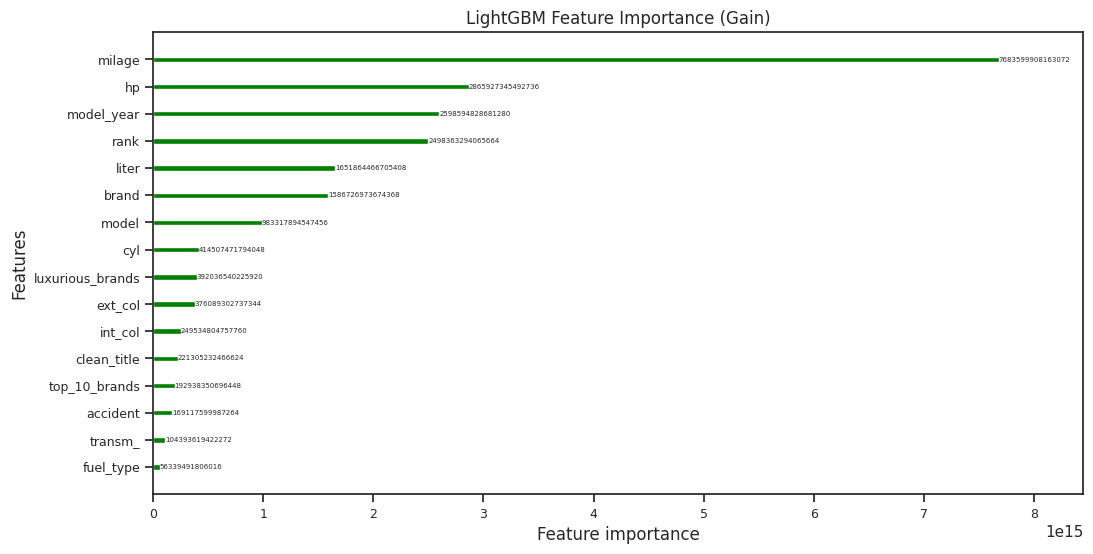

In [30]:
plt.rcParams['font.size'] = 5
lgb.plot_importance(
    lgbm_final,
    importance_type="gain",
    figsize=(12, 6),
    precision=0,
    grid=False,
    title="LightGBM Feature Importance (Gain)",
    color = "green"
)

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()
plt.rcParams.update(plt.rcParamsDefault)

## Prediction

In [31]:
y_pred_test = lgbm_final.predict(test_df_for_model)
y_pred_test

array([18881.79521109, 74109.16411768, 59319.48356766, ...,
       24203.27064235, 17453.69948281, 48489.84571348])

## Submition

In [32]:
sample_submission["price"] =  y_pred_test
sample_submission.to_csv('submission.csv',index=False)

## END

<br>
<section style="font-family:Lucida Sans Typewriter; font-size:12px;">
    <p style= "font-family:Lucida Sans Typewriter; color:#492634; font-size:13px">  
        Thank you all!</p>
</section>
